In [1]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18178 sha256=a6469d6e50ea29e96a489ad83a52006ddd14ad0cf0f292d4fd66cff2cd28121f
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [2]:
from google.colab import files

uploaded = files.upload()

## You have to navigate to Data and upload 'burgers_shock_mu_01_pi.mat'
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving burgers_shock_mu_01_pi.mat to burgers_shock_mu_01_pi.mat
User uploaded file "burgers_shock_mu_01_pi.mat" with length 157214 bytes


# Inspired from Raissi et al
# Link: https://maziarraissi.github.io/PINNs/

This notebook implementes a Physics Informed Neural Network to approximate a solution to the heat equation in 3D.

This notebook runs best in jupyter lab.





In [40]:
import torch
from tqdm import tqdm

class PINN(torch.nn.Module):
    
    def __init__(self, layers = [10,10], device = None):
        super(PINN, self).__init__() # inherit methods from torch
        
        # set to use GPU if available else cpu
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        # set nn architecture:    
        
        # store hidden layer activation function
        self.hidden_activation = torch.nn.Tanh().to(device)
        
        # initialize nn architecture:
        self.input_layer = torch.nn.Linear(3,layers[0]).to(device)
        self.input_activation = torch.nn.Tanh().to(device)
        self.hidden = torch.nn.ModuleList([torch.nn.Linear(layers[i], layers[i+1]).to(device) for i in range(len(layers)-1)])
        self.output_layer = torch.nn.Linear(layers[-1],1).to(device)
        
        
        # init weights and biases:
        
        torch.nn.init.xavier_normal_(self.input_layer.weight.data, gain=1.66)
        torch.nn.init.zeros_(self.input_layer.bias.data)
        
        for i in range(len(layers) - 1):
            
            # set weights from normal distribution 
            torch.nn.init.xavier_normal_(self.hidden[i].weight.data, gain=1.66)
            
            # init biases as zero
            torch.nn.init.zeros_(self.hidden[i].bias.data)
            
        torch.nn.init.xavier_normal_(self.output_layer.weight.data, gain=1.66)
        torch.nn.init.zeros_(self.output_layer.bias.data)
        
        
    def forward(self, x_in): 
        """Feed forward function through neural network."""
        # convert to tensor
        if torch.is_tensor(x_in) != True:         
            x_in = torch.from_numpy(x_in)
        
        # input layer
        x = self.input_layer(x_in)
        x = self.input_activation(x)
        
        # loop through hidden layers
        for i in range(len(self.hidden)):
            x = self.hidden_activation(self.hidden[i](x))
        
        x_out = self.output_layer(x)
        
        return x_out
        
    def MSE(self, y_pred, y_test):
        return torch.mean((y_pred - y_test)**2)
    
    def train_step(self, closure = True):
        '''Takes one train step, called from Train method for number of epochs.'''
        
        if closure:
            self.optimizer.zero_grad()
            
        # thermal diffisivity
        K = self.K
            
        # predict on initial condition w/ nn
        ic_pred = self.forward(self.ic_x)
        self.mse_ic = self.MSE(ic_pred, self.ic_u)
        
        # predict solution to boundary condition
        bc_pred = self.forward(self.x_bc) #[x,t]
        self.mse_u = self.MSE(bc_pred, self.u_bc)
        
        # predict u w/ network
        self.x.requires_grad = True 
        u_pred = self.forward(self.x)
        
        # differentiate using auto grad:
        
        # 1st deriv wrt X = [y,x,t]
        deriv1 = torch.autograd.grad(u_pred,
                                    self.x, #[y,x,t]
                                    torch.ones([self.x.shape[0], 1]).to(self.device),
                                    retain_graph = True,
                                    create_graph = True)[0]
        
        # 2nd deriv wrt X
        deriv2 = torch.autograd.grad(deriv1,
                                    self.x, 
                                    torch.ones(self.x.shape).to(self.device),
                                    create_graph = True)[0]
        
        du_dy = deriv1[:,[0]]
        du_dx = deriv1[:,[1]]
        du_dt = deriv1[:,[2]]
        
        d2u_dy2 = deriv2[:,[0]]
        d2u_dx2 = deriv2[:,[1]] 
        d2u_dt2 = deriv2[:,[2]] 
        
        # minimize f by incorporating into the loss
        f = du_dt - K * (d2u_dx2 + d2u_dy2) - 10.0 # == 0
        
        self.mse_f = self.MSE(f, self.f_hat)
        self.loss = self.mse_u + self.mse_f + self.mse_ic
        
        if closure:
            self.loss.backward()
            
        return self.loss
    
    def train(self, x_bc, u_bc, x, ic_x, ic_u,
              learning_rate = 1e-4,
              epochs = int(1e4),
              K = 0.1):
        
        self.K = K
        
        # boundary conditions
        self.x_bc = x_bc if torch.is_tensor(x_bc) else torch.from_numpy(x_bc).float().to(device)  
        self.u_bc = u_bc if torch.is_tensor(u_bc) else torch.from_numpy(u_bc).float().to(device)
        
        # initial conditions
        self.ic_x = ic_x if torch.is_tensor(ic_x) else torch.from_numpy(ic_x).float().to(device)  
        self.ic_u = ic_u if torch.is_tensor(ic_u) else torch.from_numpy(ic_u).float().to(device)  
        
        # f_hat(x) = 0
        self.x = x if torch.is_tensor(x) else torch.from_numpy(x).float().to(device)
        self.f_hat = torch.zeros(x.shape[0],1).to(device) # PDE is minimized to equal zero
        
        # store loss history
        self.loss_u = []
        self.loss_f = []
        loss_t = []
        

        # same optimizer used in Raissi et al, quasi-Newton method
        self.optimizer = torch.optim.LBFGS(self.parameters(), 
                              lr=0.1, 
                              max_iter = 250, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe') 
        self.optimizer.step(self.train_step) # uses closure
        
        # declar adam opt
        optimizer = torch.optim.Adam(self.parameters(), 
                       lr= learning_rate,
                       betas=(0.9, 0.999), 
                       eps=1e-08, 
                       weight_decay=0, 
                       amsgrad=False)
        
        for i in tqdm(range(epochs)):
            
            # perform train step
            loss = self.train_step(closure = False)
            loss_t.append(loss)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        return loss_t
    
    def predict(self, x_test, load_model = None):
        
        # uses pretrained model
        if load_model is not None:
            self.load_state_dict(torch.load(load_model))
        
        if torch.is_tensor(x_test) != True: # convert to tensor send to device
            x_test = torch.from_numpy(x_test).float().to(device)
        
        # feedforwards input into nn
        u_pred = self.forward(x_test) 
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = u_pred.reshape(100,256,500) 
        
        return u_pred
    
    def error(self, x_test, u_true):
        u_pred = self.forward(x_test)
        return (torch.linalg.norm((u_true-u_pred),2)/torch.linalg.norm(u_true,2)).item() # l2 error

In [41]:
torch.manual_seed(1234)
np.random.seed(1234)

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
plt.rcParams['figure.figsize'] = [15, 10]

import numpy as np
import time
from pyDOE import lhs         #Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)


In [43]:
# loads matlab solution from raissi et al, data used in init conditions
data = scipy.io.loadmat('burgers_shock_mu_01_pi.mat')  
y = data['x']                                 
x = data['t']                                   
usol = data['usol']                            

Y, X = np.meshgrid(y,x)                         

ic = usol.copy()

initial_temp = 10

ic.fill(initial_temp)

#plt.pcolormesh(X,Y,ic.T,)
#plt.colorbar()

ic = ic.T.reshape(100,1,256)

time = np.linspace(0,5, 500)
time = time.reshape(-1,1)

Y, X, T= np.meshgrid(y,x, time)

In [44]:
# test data is the 3D coordinates in [y,x,t]
test = np.hstack((Y.flatten()[:,None], X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = test[0] 
ub = test[-1] 

In [45]:
# uses ics and bcs to sample data from for training

def gen_data(n_bc = 100, n_coll = 10000, n_ic = 100):

    # initial conditions: 100 x 256 where t = 0
    init_x = np.hstack((Y[:,:,0][:,None], X[:,:,0][:,None], T[:,:,0][:,None]))
    init_u = ic

    #where x = 0 for t and y
    left_x = np.hstack((Y[0,:][:,None], X[0,:][:,None], T[0,:][:,None])) #L1
    left_u = usol[:,0][:,None] #* initial_temp #np.full([256,1], 0) #np.full([256,1], 0) 

    #where x = 1 for all t and y
    right_x = np.hstack((Y[0,:][:,None], X[-1,:][:,None], T[-1,:][:,None])) #L1
    right_u =  usol[:,0][:,None] #* initial_temp  #np.full([256,1], 0)# np.full([256,1], 0)#

    #bottom where y = -1
    bottom_x = np.hstack((Y[:,0][:,None], X[:,0][:,None], T[:,0][:,None])) #L2
    bottom_u = usol[-1,:][:,None] #np.full([100,1], 0) #

    #top where y = 1
    top_x = np.hstack((Y[:,-1][:,None], X[:,0][:,None], T[:,-1][:,None])) #L3
    top_u = usol[0,:][:,None] #np.full([100,1], 0)  #

    all_bc_x = np.vstack([
                               left_x, 
                               right_x, 
                               bottom_x, 
                               top_x]) 

    all_bc_u = np.vstack([
                             left_u, 
                             right_u, 
                             bottom_u, 
                             top_u])   

    #choose random n_bc points for training
    idx = np.random.choice(all_bc_x.shape[0], n_bc, replace=False) 

    bc_x = all_bc_x[idx, :] 
    bc_u = all_bc_u[idx,:]     

    id_x = np.random.choice(100, n_ic, replace=False) 
    id_y = np.random.choice(256, n_ic, replace=False)
    
    ic_x = init_x[id_x,:,id_y]
    ic_u = init_u[id_x,:,id_y]

    # create collocation points
    store = []
    for i in range(500):
        coll_points = lb[:2] + (ub[:2] - lb[:2]) * lhs(2,n_coll)
        # assert collocation points have been sampled from the correct range...
        assert((coll_points[:, 1] >= 0.0).all() and (coll_points[:, 1] <= 1.0).all())
        assert((coll_points[:, 0] >= -1.0).all() and (coll_points[:, 1] <= 1.0).all())
        store.append(coll_points) # coll points for every frame t

    # convert to array    
    s = np.array(store)

    t_ = np.array(([time]*n_coll))
    f_x = np.concatenate((s, t_.reshape(500, n_coll, 1)), axis = 2).reshape(n_coll, 3, 500) 

    X_u_copy = bc_x.copy()
    X_u_copy[:,0,:] = X_u_copy[:,1,:]
    X_u_copy[:,1,:] = X_u_copy[:,0,:]
    
    
    f_x = np.vstack((f_x, X_u_copy)) # append boundary coords to collocation coords
    
    return f_x, bc_x, bc_u, ic_x, ic_u

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the training data
n_bc = 100 # num boundary condition exemplars to sample
n_coll = 10000 # num coll points in each time frame to constrain f
n_ic = 100 # num init condition exemplars to sample
f_x, bc_x, bc_u, ic_x, ic_u = gen_data(n_bc, n_coll, n_ic)

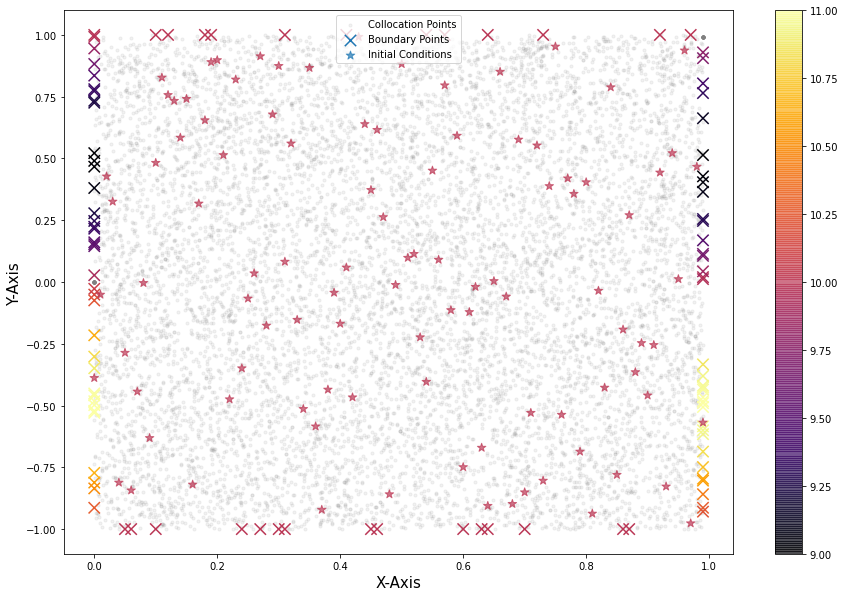

In [47]:
plt.scatter(f_x[:,0,1], f_x[:,1,1], c = 'gray', alpha = 0.1, s = 10,cmap = 'inferno',
            label = 'Collocation Points')
plt.scatter(bc_x[:,1,0], bc_x[:,0,0], marker = 'x', c = bc_u, s = 130, cmap = 'inferno',
            label = 'Boundary Points')

plt.scatter(ic_x[:,1],ic_x[:,0],  c = ic_u, marker = '*', s = 80,alpha = 0.7,cmap = 'inferno',
            label = 'Initial Conditions')
plt.xlabel('X-Axis', size = 15)
plt.ylabel('Y-Axis', size = 15)
plt.colorbar()
plt.legend(loc = 'upper center')

# this is all the info available to the PINN

In [48]:
# various neural network architectures
l1 = [50,50,50,50,50,50,50,50,50,50]
l2 = [20,20,20,20,20,20,20,20,20]
l3 = [20,50,100,100,100,100,100,100,50,20]

# instantiate PINN neural network
pinn = PINN(layers = l2, device = device)  

In [49]:
from time import time as now
t1 = now()

# pinn input: boundary condition (bc) coords, bc solution, collocation coords, initial condition (ic) coords, ic solution
loss = pinn.train(bc_x[:,:,2], bc_u, f_x[:,:,2], ic_x, ic_u,
                  epochs = 2000)
print(now() - t1)

100%|██████████| 2000/2000 [04:59<00:00,  6.69it/s]

344.43764638900757


In [50]:
# save model parameters for later use
save = False
r = np.random.random()
fname = "models/3D_heat_diffsion_{}_good_.pth".format(r)
if save:
    torch.save(pinn.state_dict(), fname)
    print('saved')
else:
    print('not saved.')

not saved.


In [51]:
from google.colab import files
use_model = False

if use_model:
  uploaded = files.upload()

  ## You have to navigate to models and upload '3D_heat_diffsion_0.948667879015219_good_.pth' to run the pretrained model
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [52]:
# load model to predict or predict from trained model
#model = "models/3D_heat_diffsion_0.29326502356412887.pth"
#m = 'models/3D_heat_diffsion_0.24116995004689978_GPU.pth'


m = '3D_heat_diffsion_0.948667879015219_good_.pth'
m = None # comment to load model

u_pred = pinn.predict(test, load_model = m)

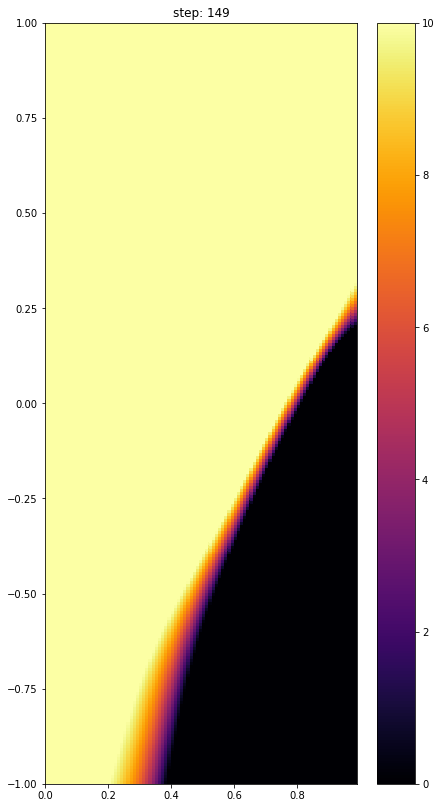

In [53]:
# play each frame
plt.rcParams['figure.figsize'] = [7, 14]


from IPython.display import clear_output
for i in range(150):
    plt.pcolormesh(X[:,:,0],Y[:,:,0], u_pred[:,:,i], vmin = 0, vmax = 10, cmap = 'inferno')
    plt.colorbar()
    plt.title('step: {}'.format(i))
    plt.show()
    
    clear_output(wait=True)

In [34]:
l1 = [50,50,50,50,50,50,50,50,50,50]
l2 = [20,20,20,20,20,20,20,20,20]
l3 = [20,50,100,100,100,100,100,100,50,20]


device = 'cpu'

# instantiate new pinn
pinn = PINN(layers = l2, device = device)  

from time import time as now
t1 = now()
for i in range(8):
    
    'Generate Training data'
    n_bc = 100 
    n_coll = 10000  
    n_ic = 100
    f_x, bc_x, bc_u, ic_x, ic_u = gen_data(n_bc,n_coll, n_ic)

    test_tensor = torch.from_numpy(test).float().to(device)
    #u = torch.from_numpy(u_true).float().to(device)
    
    loss = pinn.train(bc_x[:,:,2], bc_u, f_x[:,:,2], ic_x, ic_u,
                  epochs = 200)
    
print(now() - t1)

100%|██████████| 200/200 [00:29<00:00,  6.74it/s]

620.9990634918213


In [35]:
u_pred = pinn.predict(test)

In [36]:
from time import sleep

In [37]:
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [5, 10]

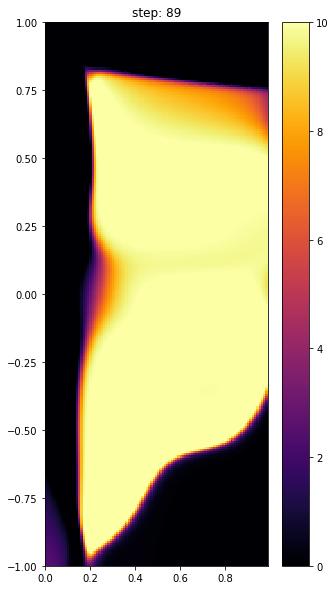

In [38]:
for i in range(90):
    plt.pcolormesh(X[:,:,0],Y[:,:,0], u_pred[:,:,i], vmin = 0, vmax = 10, cmap = 'inferno')
    plt.colorbar()
    plt.title('step: {}'.format(i))
    plt.show()
    clear_output(wait=True)
    sleep(0.15)

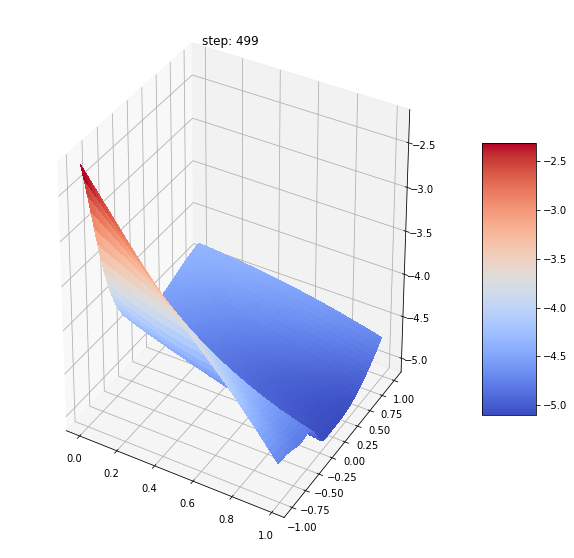

In [54]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(500):
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # Plot the surface.
    surf = ax.plot_surface(X[:,:,i],Y[:,:,i], u_pred[:,:,i], cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)#, vmin = 0, vmax = 15)
    plt.title('step: {}'.format(i))
    plt.show()
    clear_output(wait=True)